In [1]:
from glob import glob
import os 
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sns.set_style('white', {'axes.grid' : False})

def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

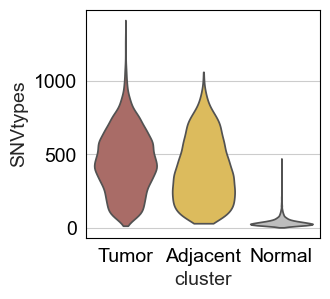

In [2]:
sample = 'CRC-P59-T_1'
rna = sc.read_h5ad(f'../../RNA_cluster/{sample}.rna.h5ad')
snv = sc.read_h5ad(f'../../SNV_process/norm/{sample}.norm_snv.h5ad')
snv.obs['cluster'] = rna.obs['cluster']
snv.uns['cluster_colors'] = ['#B4635C', '#F1C548', '#BDBDBD']
fig, ax = plt. subplots(figsize=(3,3)) 
sc.pl.violin(snv,['SNVtypes'],groupby='cluster',stripplot=False,show=False,ax = ax )
# plt.savefig(f'./MainFigure/{sample}.violin.pdf', bbox_inches='tight')
plt.show()

# fig3c

In [3]:
snv.X = snv.layers['norm']
rna.raw = rna
snv.raw = snv

In [4]:
sc.pp.scale(rna, max_value=10)
sc.pp.scale(snv, max_value=10)

In [5]:
rna.uns['log1p']['base'] =None
snv.uns['log1p'] = {}
snv.uns['log1p']['base'] =None

In [6]:
sc.tl.rank_genes_groups(rna, "cluster", groups=["Adjacent"], reference="Tumor", method="wilcoxon")

In [7]:
sc.tl.rank_genes_groups(snv, "cluster",groups=["Adjacent"], reference="Tumor", method="wilcoxon")

In [8]:
result = rna.uns["rank_genes_groups"]
groups = result["names"].dtype.names
rnalfc = pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals",'logfoldchanges']
    }
)

In [9]:
result = snv.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pair_snvlfc = pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals",'logfoldchanges']
    }
)

In [10]:
sc.tl.rank_genes_groups(snv, "cluster", method="wilcoxon")

In [11]:
result = snv.uns["rank_genes_groups"]
groups = result["names"].dtype.names
total_snvlfc = pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals",'logfoldchanges']
    }
)

In [12]:
region = 'Tumor'
tumor_set = set(total_snvlfc[(total_snvlfc[f'{region}_p']<0.05) & (total_snvlfc[f'{region}_l']>0)][f'{region}_n'].tolist())
region = 'Adjacent'
ad_set = set(total_snvlfc[(total_snvlfc[f'{region}_p']<0.05) & (total_snvlfc[f'{region}_l']>0)][f'{region}_n'].tolist())
region = 'Normal'
normal_set = set(total_snvlfc[(total_snvlfc[f'{region}_p']<0.05) & (total_snvlfc[f'{region}_l']>0)][f'{region}_n'].tolist())

In [13]:
from matplotlib_venn import venn3

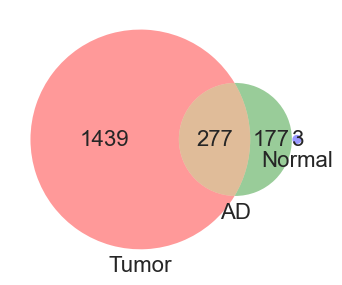

In [14]:
plt.figure(figsize=(4,4))
venn = venn3([tumor_set, ad_set, normal_set], set_labels=('Tumor', 'AD', 'Normal'))

for circle in venn.set_labels:
    circle.set_size(16)
for label in venn.subset_labels:
    if label:
        label.set_fontsize(16)
# plt.savefig(f'./MainFigure///{sample}.deg.pdf', bbox_inches='tight')
plt.show()

In [15]:
spcific = pd.DataFrame((ad_set - tumor_set))

In [16]:
genedict = dict(zip(snv.var['gene_ids'],snv.var['gene_name']))
funcdict = dict(zip(snv.var['gene_ids'],snv.var['Func_L0']))
spcific['gene'] = spcific[0].map(genedict)
spcific['func'] = spcific[0].map(funcdict)

In [17]:
spcific['genemo'] = spcific['gene'].apply(lambda x : x.split(';')[0])

In [19]:
# spcific['genemo'].drop_duplicates().to_csv('./GO_ana/ad_spcific.csv',index=None,header=None)

# specfic

In [18]:
pair_snvlfc['func'] = pair_snvlfc['Adjacent_n'].map(dict(zip(snv.var['gene_ids'],snv.var['Func_L0'])))
pair_snvlfc['gene'] = pair_snvlfc['Adjacent_n'].map(dict(zip(snv.var['gene_ids'],snv.var['gene_name'])))
gene_dict = dict(zip(rnalfc['Adjacent_n'],rnalfc['Adjacent_l']))
gene_p_dict = dict(zip(rnalfc['Adjacent_n'],rnalfc['Adjacent_p']))

pair_snvlfc['rna_l'] = pair_snvlfc['gene'].apply(lambda x : [ gene_dict.get(i) for i in x.split(';')])
pair_snvlfc['rna_p'] = pair_snvlfc['gene'].apply(lambda x : [ gene_p_dict.get(i) for i in x.split(';')])
snvlfc = pair_snvlfc[pair_snvlfc['rna_l'].map(len)==1].copy()
snvlfc['rna_l'] = snvlfc['rna_l'].map(lambda x: x[0])
snvlfc['rna_p'] = snvlfc['rna_p'].map(lambda x: x[0])

In [19]:
adsnvlfc = snvlfc[['Adjacent_n','Adjacent_l','func','Adjacent_p']]
adsnvlfc = adsnvlfc[adsnvlfc['Adjacent_p']<0.05]

In [20]:
total_list = []
total_list.extend(adsnvlfc[adsnvlfc['func'] == 'UTR'].sort_values('Adjacent_l',ascending=False)[:3]['Adjacent_n'].tolist())
total_list.extend(adsnvlfc[adsnvlfc['func'] == 'Exonic'].sort_values('Adjacent_l',ascending=False)[:3]['Adjacent_n'].tolist())
total_list.extend(adsnvlfc[adsnvlfc['func'] == 'Intronic'].sort_values('Adjacent_l',ascending=False)[:3]['Adjacent_n'].tolist())
total_list.extend(adsnvlfc[adsnvlfc['func'] == 'Intergenic'].sort_values('Adjacent_l',ascending=False)[:3]['Adjacent_n'].tolist())

In [21]:
total_list = adsnvlfc[:15]['Adjacent_n'].tolist()

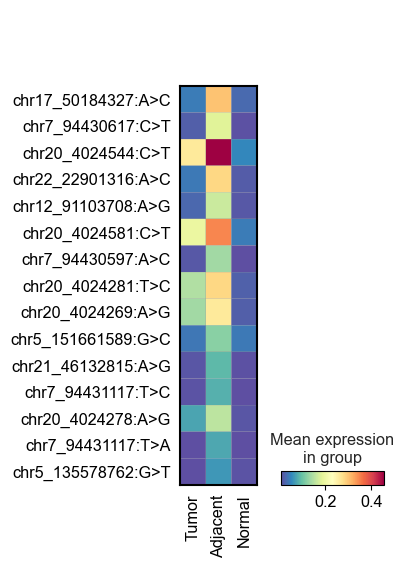

In [22]:
sc.pl.matrixplot(snv,total_list,groupby = 'cluster',cmap = 'Spectral_r',swap_axes = True)#,save = 'top.hm.pdf')

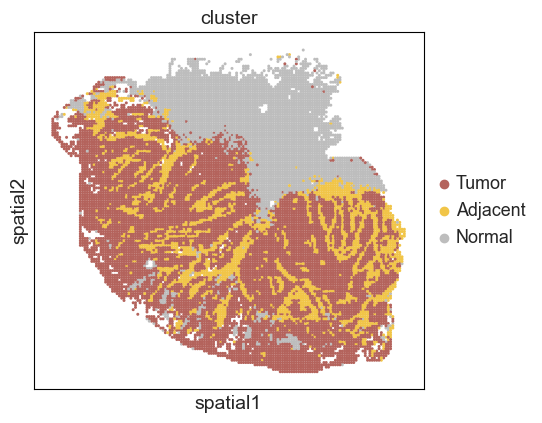

In [23]:
fig,ax = plt.subplots(figsize = (5,5))
sc.pl.spatial(snv,color = 'cluster',basis = 'spatial',spot_size = 130,show = False,ax = ax)
# fig.savefig(f'./MainFigure/Fig3B.cluster.spatial.pdf', bbox_inches='tight')
fig.show()

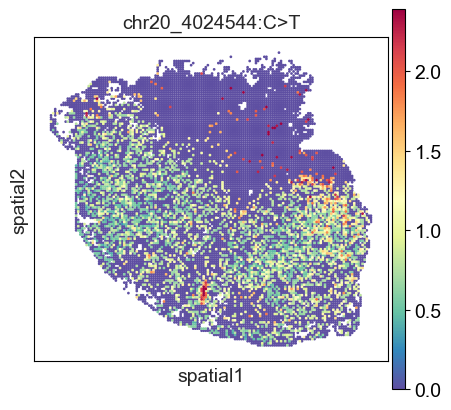

In [24]:
fig,ax = plt.subplots(figsize = (5,5))
sc.pl.spatial(snv,color = ['chr20_4024544:C>T'],basis = 'spatial',spot_size = 130,show = False,ax = ax,vmax = 'p99.9',cmap = 'Spectral_r')
# fig.savefig(f'./MainFigure/Fig3B.spatial.a.pdf', bbox_inches='tight')
fig.show()

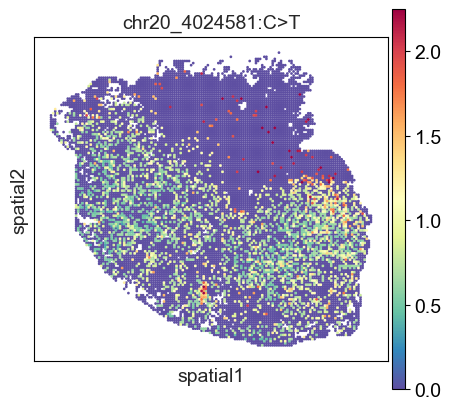

In [25]:
fig,ax = plt.subplots(figsize = (5,5))
sc.pl.spatial(snv,color = ['chr20_4024581:C>T'],basis = 'spatial',spot_size = 130,show = False,ax = ax,vmax = 'p99.9',cmap = 'Spectral_r')
# fig.savefig(f'./MainFigure/Fig3B.spatial.b.pdf', bbox_inches='tight')
fig.show()

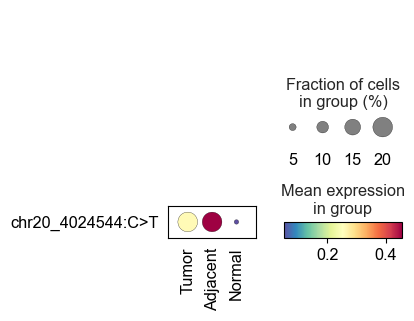

In [26]:
fig,ax = plt.subplots(figsize = (3,3))
sc.pl.dotplot(snv,'chr20_4024544:C>T',groupby = 'cluster',cmap = 'Spectral_r',swap_axes=True,dot_max = 0.2,show = False,ax = ax)
# fig.savefig(f'./MainFigure/Fig3B.dotplot.pdf', bbox_inches='tight')
fig.show()

In [27]:
tmp = snv.obs['cluster'].reset_index()
tmp['x'] = tmp['index'].apply(lambda x : x.split('_')[1]) 
tmp['y'] = tmp['index'].apply(lambda x : x.split('_')[2]) 
tmp = tmp.rename({'cluster':'RNA_cluster'},axis = 1)
tmp.to_csv('CRC-P59-T_1_cluster.csv')

# gsva

In [28]:
gsvadf = pd.read_csv('../../GSVA/CRC-P59-T_1.gsva.csv',index_col = 0).T

In [29]:
from anndata import AnnData

In [30]:
gsva = AnnData(gsvadf)

In [31]:
gsva = gsva[gsva.obs_names.isin(rna.obs_names)][rna.obs_names].copy()

In [32]:
gsva.obs['cluster'] = rna.obs['cluster']
gsva.obsm['spatial'] = rna.obsm['spatial']

In [33]:
sc.pp.scale(gsva,max_value=10)

In [34]:
sc.tl.rank_genes_groups(gsva, "cluster",groups=["Adjacent"], reference="Tumor", method="wilcoxon")

/home/liuyi/miniconda3/envs/SpatialBase/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [35]:
result = gsva.uns["rank_genes_groups"]
groups = result["names"].dtype.names
gsvalfc = pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals",'logfoldchanges']
    }
)

In [36]:
data  = gsvalfc

In [37]:
def plot_density(df, palette=None, groupby='cluster', key='ros',save = None):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    if palette is None:
        palette = sns.color_palette("Set3", n_colors=df[groupby].nunique())
    g = sns.FacetGrid(df, row=groupby, hue=groupby, aspect=5, height= 1, palette=palette)
    g.map(sns.kdeplot, key, bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, key, clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
    def add_median_line(data, **kwargs):
        median_val = data.median()
        plt.axvline(median_val, color='black', linestyle='--', linewidth=1,ymax = 0.2)
        g.map(add_median_line, key)
    
    def label(data, color, label, **kwargs):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

    g.map(label, key)
    
    g.figure.subplots_adjust(hspace=-.25)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    if save != None:
        g.savefig(save, bbox_inches='tight')
    plt.show()

In [38]:
gsva.obs['ir'] = np.sum(gsva[:,gsva.var_names == "HALLMARK_INFLAMMATORY_RESPONSE"].X,axis =1)
gsva.obs['my'] = np.sum(gsva[:,gsva.var_names == "HALLMARK_HYPOXIA"].X,axis =1)
palette = {'Tumor': '#C15E58', 'Adjacent': '#FAC319', 'Normal': '#BDBDBD'}
mydf = pd.DataFrame({'my': gsva.obs['my'], 'cluster': gsva.obs['cluster']})
irdf = pd.DataFrame({'ir': gsva.obs['ir'], 'cluster': gsva.obs['cluster']})

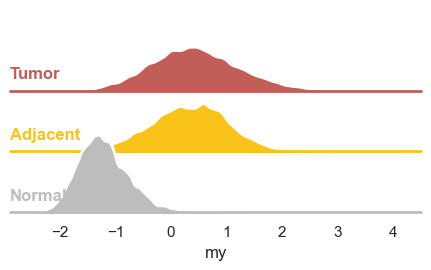

In [39]:
plot_density(mydf,groupby='cluster', key = 'my',palette=palette)#,save = "./MainFigure/Fig3G.hypoxia.pdf")

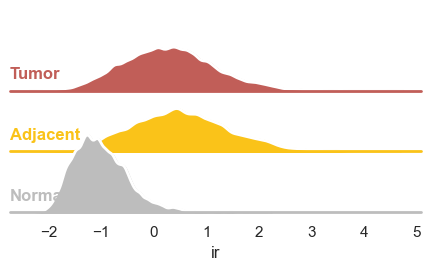

In [40]:
plot_density(irdf,groupby='cluster', key = 'ir',palette=palette)#,save = "./MainFigure/Fig3G.INFLAMMATORY_RESPONSE.pdf")

In [41]:
gsva.obs['snvperumi'] = snv.obs['snvperumi']

In [42]:
from sklearn.neighbors import KDTree
from scipy.stats import spearmanr

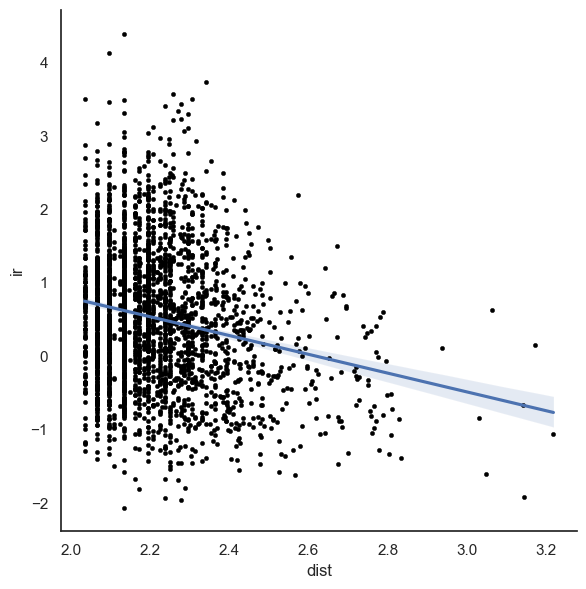

In [44]:
tree = KDTree(gsva.obsm['spatial'][gsva.obs['cluster']=='Tumor',:])
query = tree.query(gsva.obsm['spatial'][gsva.obs['cluster']=='Adjacent',:], k = 5)
count = gsva.obs.loc[gsva.obs['cluster']=='Adjacent',['ir']]
count['dist']= query[0].mean(axis=1)
count['dist'] = np.log10(count['dist'])
g = sns.lmplot(data=count, x='dist', y='ir',height=6,scatter_kws = {'s': 0})
for ax in g.axes.flatten():
    sns.scatterplot(data = count, x= 'dist',y = 'ir',color = 'black',s= 10,edgecolor = None,ax =ax)
ax.grid(False)
g.savefig('./SupFigure/ir_dist.pdf')

In [45]:
corr, p_value = spearmanr(count['dist'], count['ir'])
print(corr,p_value)

-0.15089727289885274 1.3676768418118969e-15


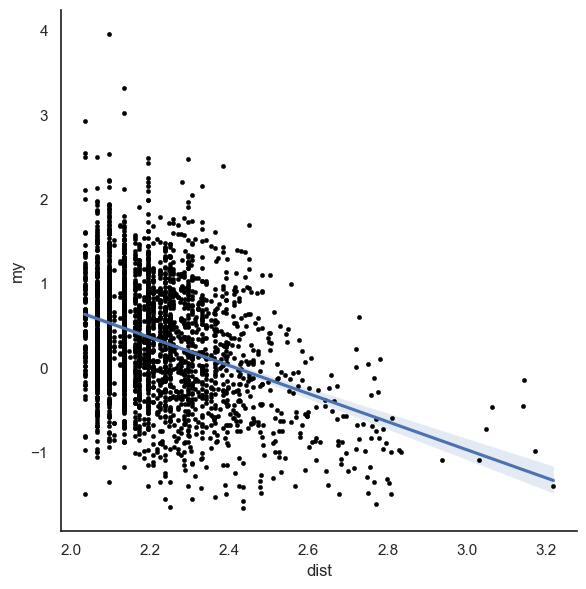

In [46]:
tree = KDTree(gsva.obsm['spatial'][gsva.obs['cluster']=='Tumor',:])
query = tree.query(gsva.obsm['spatial'][gsva.obs['cluster']=='Adjacent',:], k = 5)
count = gsva.obs.loc[gsva.obs['cluster']=='Adjacent',['my']]
count['dist']= query[0].mean(axis=1)

count['dist'] = np.log10(count['dist'])
g = sns.lmplot(data=count, x='dist', y='my',height=6,scatter_kws = {'s': 0})
for ax in g.axes.flatten():
    sns.scatterplot(data = count, x= 'dist',y = 'my',color = 'black',s= 10,edgecolor = None,ax =ax)
ax.grid(False)
g.savefig('./SupFigure/hypoxia_dist.pdf')

In [47]:
corr, p_value = spearmanr(count['dist'], count['my'])
print(corr,p_value)

-0.27183401549437064 3.571977491877787e-48


In [49]:
from sklearn.neighbors import KDTree
from scipy.interpolate import CubicSpline
import scipy

In [ ]:
slope_list = []
fig,axs = plt.subplots(2,3,figsize = (10,6),sharex=False,sharey=False)
m = 0
for sample in ['CRC-P19-T', 'CRC-P59-T_1', 'CRC-P59-T_2', 'CRC-P67-T', 'LC05-M_DU3','LC05-T_FD3']:
    ax = axs[m//3][m%3]
    m += 1
    print(f'>>{sample}')
    rna = sc.read_h5ad(f'../../RNA_cluster/{sample}.rna.h5ad')
    snv = sc.read_h5ad(f'../../SNV_process/norm//{sample}.norm_snv.h5ad')
    snv.obs['cluster'] = rna.obs['cluster']
    snv.X = snv.layers['norm']
    tree = KDTree(snv.obsm['spatial'][snv.obs['cluster']=='Tumor',:])
    query = tree.query(snv.obsm['spatial'][snv.obs['cluster']=='Adjacent',:], k = 5)
    count = snv.obs.loc[snv.obs['cluster']=='Adjacent',['snvperumi']]
    count['dist']= query[0].mean(axis=1)
    count['logdist'] = np.log(count['dist'])
    count['logsnv'] = np.log(count['snvperumi'])
    if sample in ['CRC-P19-T', 'CRC-P59-T_1', 'CRC-P59-T_2', 'CRC-P67-T']:
        color = '#EFAE95'
    else:
        color = "#74A8CE"
    p = sns.regplot(data = count,x= 'logdist' ,y = 'logsnv',color = color,scatter_kws = {'s':1,"rasterized":True},ax =ax)
    tslope, tintercept, tr_value, tp_value, tstd_err = scipy.stats.linregress(x = count['logdist'],y = count['logsnv'])
    print(tslope,tr_value*tr_value)
    equation_text = f'y = {tslope:.2f}x + {tintercept:.2f}\n R = {tr_value:.2f}'
    ax.text(0.6, 0.95, equation_text, transform=ax.transAxes, fontsize=7, verticalalignment='top')
    ax.set_xlabel('')
    ax.set_ylabel('')
    slope_list.append([sample,tslope])
# fig.savefig('./MainFigure/Fig2d.pdf',bbox_inches = 'tight' )

>>CRC-P19-T
-0.5468293294547706 0.524724461434573
>>CRC-P59-T_1
-0.5912228424484818 0.27555018692899585
>>CRC-P59-T_2
-0.15905549113535739 0.22703798128333444
>>CRC-P67-T
-0.27595524886534034 0.26086238335935535
>>LC05-M_DU3
-0.1391065156856142 0.3620384162258737
>>LC05-T_FD3
-0.07120737392093701 0.01921398562895348


In [ ]:
slopedf = pd.DataFrame(slope_list,columns = ['sample','slope']).set_index('sample')

In [ ]:
gsva = pd.read_csv('./combine.gsva.csv',index_col = 0).T
estimate = pd.read_csv('./combine.estimate.csv',index_col = 0).T

In [ ]:
slopedf['ESTIMATEScore'] = estimate['ESTIMATEScore']
#slopedf['color'] = ['#EFAE95']*4+ ['#74A8CE']*2
slopedf['color'] = ['#D99590','#E69F8F','#EFBA9C','#F6E3C3','#89A6CD','#C1A0C7']

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(3, 3))

for idx,sample in enumerate(slopedf.index):
    tmp = slopedf.loc[sample]
    # ax.scatter(y=np.abs(slopedf['slope']), x=slopedf['ESTIMATEScore'], color=slopedf['color'], s=100, ax=ax,edgecolor = 'black',legend=True)
    ax.scatter(y = np.abs(tmp['slope']),x = tmp['ESTIMATEScore'],color = tmp['color'],s = 100,edgecolor = 'black',label = sample)
sns.regplot(y=np.abs(slopedf['slope']), x=slopedf['ESTIMATEScore'], color = 'grey',scatter=False, ax=ax)
ax.set_ylim(0,0.7)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig('./MainFigure/Fig2e.esitamate.pdf',bbox_inches = 'tight')